In [13]:
# ===================================
# !!! SET UP PATH AND MERGE FILES !!!
# ===================================

import csv
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
import os

Nchunk = 20
trials = 1e4
directory = '/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_03_intermediate/'
nfolders = ['tesi_intermediate_nominal_noEBL/']#, 'tesi_intermediate_nominal_EBL']
dfolders = ['tesi_intermediate_degraded_noEBL/']#, 'tesi_degraded_nominal_EBL']
folders = nfolders + dfolders

print(dfolders, nfolders, folders)

['tesi_intermediate_degraded_noEBL/'] ['tesi_intermediate_nominal_noEBL/'] ['tesi_intermediate_nominal_noEBL/', 'tesi_intermediate_degraded_noEBL/']


In [19]:
for i, f in enumerate(folders):
    os.system('mkdir %s/png' %(directory+f))
    path = directory + f + 'run0406/run0406_ID000126/csv/'

    texp = [1,5,10,100]
    sigma = [5]
    chunk = [i+1 for i in range(Nchunk)]

    csvName = [[]*i for i in range(len(texp))]
    for i in range(len(chunk)) :  
        for j in range(len(texp)) :
            csvName[j].append('run0406_%ds_chunk%02d.csv' % (texp[j], chunk[i]))
            
    # merge files ---!
    csvMerged = []
    for j in range(len(texp)) :
        csvMerged.append('run0406_%ds.csv' %texp[j])

        fout = open(path+csvMerged[j],'w+')
        # first file ---!
        for line in open(path+csvName[j][0]):
            fout.write(line)
        # remaining files ---!    
        for i in range(len(chunk)-1):
            f = open(path+csvName[j][i+1])
            next(f) # skip the header ---!
            for line in f:
                 fout.write(line)
            f.close() 
        fout.close()

    print(csvMerged)
print('done')

['run0406_1s.csv', 'run0406_5s.csv', 'run0406_10s.csv', 'run0406_100s.csv']
['run0406_1s.csv', 'run0406_5s.csv', 'run0406_10s.csv', 'run0406_100s.csv']
done


In [15]:
# reformat files ---!
#for f in csvMerged:
#    with open(path+f, 'r') as inp, open(path+f.replace('.csv', '_mod.csv'), 'w') as out:
#        writer = csv.writer(out)
#        for row in csv.reader(inp):
#            if len(row) == 6 and ('ID' in row[0] or '#' in row[0]):
#                writer.writerow(row)


#for index, f in enumerate(csvMerged):
#    csvMerged[index] = f.replace('.csv', '_mod.csv')
#print(csvMerged)

In [20]:
# data params ---!
threshold = 0.5
ts_threshold = 9
xlim=0.2
# initialize SphDistance calc ---!
trueRA = 33.057
trueDEC = -51.841
true_coord = SkyCoord(ra = trueRA*u.deg, dec = trueDEC*u.deg, frame='fk5')

In [25]:
# ------------------------------------------ plots ---!
def plottage(texp, ra, dec, pos, std_ra, std_dec, trueRA, trueDEC, png_path, lset=None):

    c = ['darkgreen', 'red', 'navy', 'gold']
    alpha = 0.3
    hist=True
    
    # conf intervals params ---!
    nstd = [1,2,3,5]
    conf_probs = [0.6827, 0.9545, 0.9973, 0.99994]
    # img params ---!
    fontsize=12
    CI_colors = ['k', 'r', 'g', 'w']

    # DETECTION 1D ---!
    fig, ax = hist1d_gauss(ra, mean=None, loc=trueRA, threshold=threshold, nbin=Dnbin, width=Dwidth,
                           fontsize=fontsize, color=c, alpha=alpha, hist=hist,
                           title='detected RA distribution', 
                           xlabel='RA (deg)', ylabel='counts density',
                           filename=png_path+'run0406_detRA_h%s.png' %str(hist))   
    plt.show()
    plt.close()

    fig, ax = hist1d_gauss(dec, mean=None, loc=trueDEC, nbin=Dnbin, width=Dwidth,
                           threshold=threshold, fontsize=fontsize, color=c, alpha=alpha,
                           title='detected DEC distribution', hist=hist, 
                           xlabel='DEC (deg)', ylabel='counts density',
                           filename=png_path+'run0406_detDEC_h%s.png' %str(hist)) 
    plt.show()
    plt.close()

    fig, ax = hist1d_rayleigh(pos, mean=None, rayleigh_prms={'loc':0, 'scale':None}, 
                              threshold=threshold, nbin=Dnbin, width=Dwidth, fontsize=fontsize, 
                              color=c, alpha=alpha, hist=hist,
                              title='detected $\\Delta \\Theta$ distribution',
                              xlabel='$\\Delta \\Theta$ (deg)', ylabel='counts density',
                              filename=png_path+'run0406_detPOS_h%s.png' %str(hist))
    plt.show()
    plt.close()

    
    
print('\n\nok')



ok


In [26]:
# =============================
# !!! ALL STATISTICAL PLOTS !!!
# =============================

import matplotlib.pyplot as plt
import seaborn as sns
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from scipy.stats import rayleigh, norm
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse, Circle, Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
sys.path.append('/home/ambra/Desktop/cluster-morgana/')
from module_statistics import *
from statistics import mean

for index, f in enumerate(folders):
    print('\n' + f)
    path = directory + f + 'run0406/run0406_ID000126/csv/'
    png_path = directory + f + 'png/'
    if not os.path.isdir(png_path):
        os.mkdir(png_path)
    
    # hist params ---!
    Dwidth = 0.02
    Dnbin = int(threshold / Dwidth)

    list_ra, list_dec, list_pos = ([] for j in range(3))
    list_mode_pos, list_mean_ra, list_mean_dec, list_mean_pos = ([] for j in range(4))
    list_std_ra, list_std_dec = ([] for j in range(2))
    list_flux, list_mean_flux, list_std_flux = ([] for j in range(3))
    flux_threshold = []
    
    for n in range(len(texp)) :  

        # store values ---!
        filename = csvMerged[n]
        print('\n================ texp = %ds ==============\n' %texp[n])

        # load DataFrame and column names ---!
        df = pd.read_csv(path+filename)
        cols = list(df.columns)
        trials = len(df[cols[0]])
        print('* verify trials = ', trials)  
        # drop duplicates ---! 
        df.sort_values(cols[0], inplace = True) 
        # dropping ALL duplicte values 
        df.drop_duplicates(subset=cols[0], keep='last', inplace=True) 
        trials = len(df[cols[0]])
        print('* drop duplicate => trials = ', trials) 
        total = trials
        # drop NaN ---!
        df = df.dropna()
        trials = len(df[cols[0]])
        #df = df.reindex(np.arange(trials))
        print('* drop nan => trials = ', trials)  
        perc = 100 * (trials/total)
        print('! NaN DETECTION RATE :', 100-perc, '%')

        trial = np.array(df[cols[0]])
        raDet = np.array(df[cols[-2]])
        decDet = np.array(df[cols[-1]])

        perc = 100 * (trials/total)
        print('! DETECTION RATE :', perc, '%')

        # DETECTION ---!
        distance_det = []
        d_det = []
        ra_det = []
        dec_det = []

        for i in range(len(raDet)) :
            if -90 <= decDet[i] and decDet[i] <= 90 and 0 <= raDet[i] and raDet[i] <= 360 :
                det_coord = SkyCoord(ra = raDet[i]*u.deg, dec = decDet[i]*u.deg, frame='fk5')
                dist = float(true_coord.separation(det_coord).deg)
                distance_det.append(dist)                  

                if dist < threshold :
                    d_det.append(dist)
                    ra_det.append(raDet[i]) 
                    dec_det.append(decDet[i]) 

        perc_det = len(d_det)/total * 100
        print('! DET RATIO WITHIN %.1fdeg FROM TRUE POSITION:' %threshold, perc_det, '%')

        # MEAN DET ---!
        mean_raDet = np.nanmean(ra_det)
        std_raDet = np.nanstd(ra_det)
        mean_decDet = np.nanmean(dec_det)
        std_decDet = np.nanstd(dec_det)
        mean_posDet = np.nanmean(d_det)

        tmp = 0
        for i in range(len(d_det)) :
            tmp += d_det[i]**2

        if len(d_det) != 0.0 :
            mode_det = np.sqrt(1/(2*len(d_det)) * tmp)   
            MLE_det = 0.606/mode_det
        else:
            mode_det = np.nan
            MLE_det = np.nan
            
        print('~ ra det mean:', mean_raDet, 'ra det std:', std_raDet)
        print('~ dec det mean:', mean_decDet, 'dec det std:', std_decDet)
        print('~ pos det mean:', mean_posDet, 'pos det gamma:', mode_det)

        list_ra.append(ra_det)
        list_dec.append(dec_det)
        list_pos.append(d_det)
        list_mean_ra.append(mean_raDet)
        list_mean_dec.append(mean_decDet)
        list_mean_pos.append(mean_posDet)
        list_std_ra.append(std_raDet)
        list_std_dec.append(std_decDet)
        list_mode_pos.append(mode_det)

    # gathered per texp
    plottage(texp, list_ra, list_dec, list_pos, list_std_ra, list_std_dec, list_mode_pos, 
             trueRA, trueDEC, png_path)
    print('done plotting')
print('done')


tesi_intermediate_nominal_noEBL/

================ texp = 1s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DETECTION RATE : 100.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 2.65 %
~ ra det mean: 33.14236426951342 ra det std: 0.38145657704852404
~ dec det mean: -51.79414896370302 dec det std: 0.2514251405033967
~ pos det mean: 0.3315683190387822 pos det gamma: 0.2487573580861128

================ texp = 5s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  9999
! NaN DETECTION RATE : 0.010000000000005116 %
! DETECTION RATE : 99.99 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 2.37 %
~ ra det mean: 33.15566573910816 ra det std: 0.3970876711505263
~ dec det mean: -51.810631472587175 dec det std: 0.2573240825235451
~ pos det mean: 0.34303200019810415 pos det gamma: 0.255944674307906

================ texp = 10s ==============

* verify trials

TypeError: unsupported operand type(s) for +: 'float' and 'str'


tesi_1e4_nominal_tmin90s50s_flux1/
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
* drop TS<25 => trials =  9836
! DETECTION RATE : 98.36 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 98.36 %
~ ra det mean: 33.05732760852045 ra det std: 0.019155230542163396
~ dec det mean: -51.840784487544255 dec det std: 0.01209530561101388
~ pos det mean: 0.015281985276256762 pos det gamma: 0.011967672123765491
~ flux mean: 5.2984493819350536e-09 flux std: 6.955130504871969e-10
~ TS mean: 280.85396990646603 TS std: 53.17862988865161

tesi_1e4_nominal_tmin90s50s_flux2/
* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  9979
! NaN DETECTION RATE : 0.20999999999999375 %
* drop TS<25 => trials =  9758
! DETECTION RATE : 97.58 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 97.36 %
~ ra det mean: 33.057941349630894 ra det std: 0.02800602820750529
~ dec det mean: -51.840386389752325 dec det std: 0.

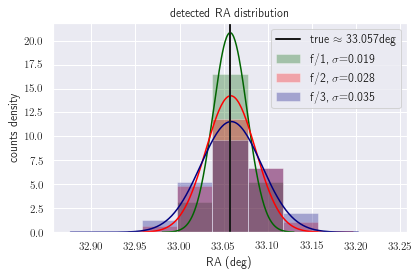

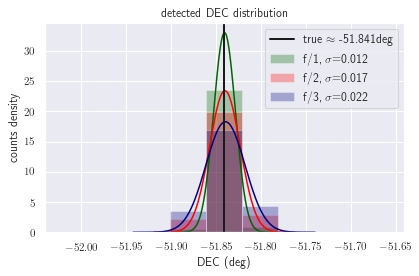

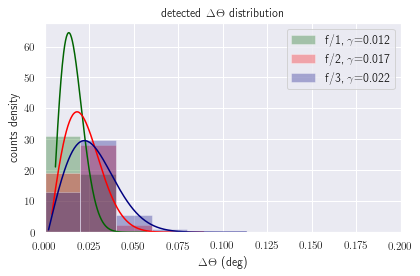

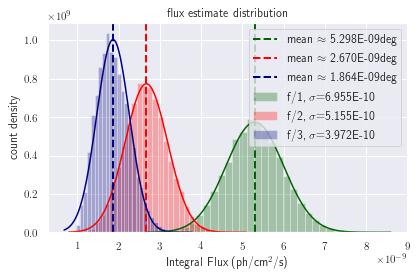

done plotting
done


In [49]:
# ======================
# !!! ALL FLUX PLOTS !!!
# ======================

import matplotlib.pyplot as plt
import seaborn as sns
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from scipy.stats import rayleigh, norm
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse, Circle, Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
sys.path.append('/home/ambra/Desktop/cluster-morgana/')
from module_statistics import *
from statistics import mean

fluxes = [1, 2, 3]
list_ra, list_dec, list_pos = ([] for j in range(3))
list_mode_pos, list_mean_ra, list_mean_dec, list_mean_pos = ([] for j in range(4))
list_std_ra, list_std_dec = ([] for j in range(2))
list_flux, list_mean_flux, list_std_flux = ([] for j in range(3))
flux_threshold = []

for index, f in enumerate(nfolders):
    print('\n' + f)
    path = directory + f + 'run0406/run0406_ID000126/csv/'
    png_path = directory + 'tesi_final_results/png/'
    if not os.path.isdir(png_path):
        os.mkdir(png_path)
    
    # hist params ---!
    Dwidth = 0.02
    Dnbin = int(threshold / Dwidth)
    
#    for n in range(len(fluxes)) :  

    # store values ---!
    filename = 'data_%ds.csv' %texp[0]

    # load DataFrame and column names ---!
    df = pd.read_csv(path+filename)
    cols = list(df.columns)
    trials = len(df[cols[0]])
    print('* verify trials = ', trials)  
    # drop duplicates ---! 
    df.sort_values(cols[0], inplace = True) 
    # dropping ALL duplicte values 
    df.drop_duplicates(subset=cols[0], keep='last', inplace=True) 
    trials = len(df[cols[0]])
    print('* drop duplicate => trials = ', trials) 
    total = trials
    # drop NaN ---!
    df = df.dropna()
    trials = len(df[cols[0]])
    df = df.reindex(np.arange(trials))
    print('* drop nan => trials = ', trials)  
    # set arrays ---!
    # 0      1     2      3     4     5       6        7       8        9        10/-1  
    # trial, texp, sigma, Ndet, Nsrc, RA_det, DEC_det, RA_fit, DEC_fit, flux_ph, TS
    ts = np.array(df[cols[-1]]) 
    trials = len(ts)
    df = df.reindex(np.arange(trials))
    perc = 100 * (trials/total)
    print('! NaN DETECTION RATE :', 100-perc, '%')

    for i, val in enumerate(ts):
        if val < ts_threshold:
            df = df.drop([i])

    trial = np.array(df[cols[0]])
    raDet = np.array(df[cols[5]])
    decDet = np.array(df[cols[6]])
    raFit = np.array(df[cols[7]])
    decFit = np.array(df[cols[8]])
    flux = np.array(df[cols[9]]) 
    ts = np.array(df[cols[-1]])

    trials = len(df[cols[0]])
    df = df.reindex(np.arange(trials))
    print('* drop TS<25 => trials = ', trials)  

    perc = 100 * (trials/total)
    print('! DETECTION RATE :', perc, '%')

    # DETECTION ---!
    distance_det = []
    d_det = []
    ra_det = []
    dec_det = []
    flux_det = []

    for i in range(len(raDet)) :
        if -90 <= decDet[i] and decDet[i] <= 90 and 0 <= raDet[i] and raDet[i] <= 360 :
            det_coord = SkyCoord(ra = raDet[i]*u.deg, dec = decDet[i]*u.deg, frame='fk5')
            dist = float(true_coord.separation(det_coord).deg)
            distance_det.append(dist)                  

            if dist < threshold :
                d_det.append(dist)
                ra_det.append(raDet[i]) 
                dec_det.append(decDet[i]) 
                flux_det.append(flux[i])

    perc_det = len(d_det)/total * 100
    print('! DET RATIO WITHIN %.1fdeg FROM TRUE POSITION:' %threshold, perc_det, '%')

    # MEAN DET ---!
    mean_raDet = np.nanmean(ra_det)
    std_raDet = np.nanstd(ra_det)
    mean_decDet = np.nanmean(dec_det)
    std_decDet = np.nanstd(dec_det)
    mean_posDet = np.nanmean(d_det)
    mean_flux = np.nanmean(flux_det)
    std_flux = np.nanstd(flux_det)

    tmp = 0
    for i in range(len(d_det)) :
        tmp += d_det[i]**2

    if len(d_det) != 0.0 :
        mode_det = np.sqrt(1/(2*len(d_det)) * tmp)   
        MLE_det = 0.606/mode_det
    else:
        mode_det = np.nan
        MLE_det = np.nan

    print('~ ra det mean:', mean_raDet, 'ra det std:', std_raDet)
    print('~ dec det mean:', mean_decDet, 'dec det std:', std_decDet)
    print('~ pos det mean:', mean_posDet, 'pos det gamma:', mode_det)
    print('~ flux mean:', mean_flux, 'flux std:', std_flux)
    print('~ TS mean:', np.nanmean(ts), 'TS std:', np.nanstd(ts))


    list_ra.append(ra_det)
    list_dec.append(dec_det)
    list_pos.append(d_det)
    list_flux.append(flux_det)
    list_mean_ra.append(mean_raDet)
    list_mean_dec.append(mean_decDet)
    list_mean_pos.append(mean_posDet)
    list_mean_flux.append(mean_flux)
    list_std_ra.append(std_raDet)
    list_std_dec.append(std_decDet)
    list_mode_pos.append(mode_det)
    list_std_flux.append(std_flux)
    flux_threshold.append(mean_flux-np.min(flux_det))
    flux_threshold.append(np.max(flux_det)-mean_flux)
        

# gathered per texp
print(len(list_std_ra))
plottage(texp, list_ra, list_dec, list_pos, list_flux, list_mean_flux,
             list_std_ra, list_std_dec, list_mode_pos, list_std_flux, 
             trueRA, trueDEC, png_path, lset='flux')
print('done plotting')
print('done')

In [ ]:
# KDE SIZE = SKYMAP PIXEL-SIZE

# library & dataset
import seaborn as sns
 
# Basic 2D density plot
sns.set_style("white")
sns.kdeplot(ra_det, dec_det, n_levels=5, bw=Dwidth, cbar=True, color='red')
plt.show()

# Custom it with the same argument as 1D density plot
sns.kdeplot(ra_det, dec_det, n_levels=100, cmap="jet", shade=True, bw=Dwidth, cbar=True)
plt.show()

# Some features are characteristic of 2D: color palette and wether or not color the lowest range
sns.kdeplot(ra_det, dec_det, cmap="Blues", shade=True, shade_lowest=True, bw=Dwidth, cbar=True)
plt.show()

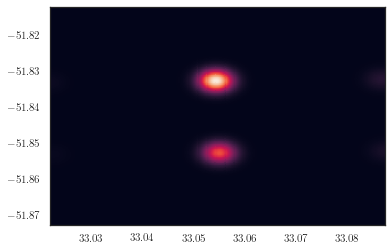

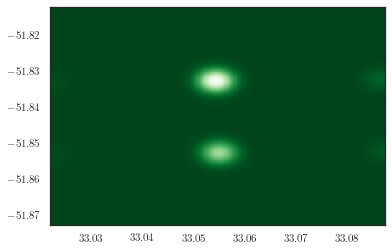

In [8]:
# ESTIMATE KDE FROM DATA

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kde
 
# create data
x = np.array(ra_det)
y = np.array(dec_det)
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.show()
 
# Change color palette
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Greens_r)
plt.show()
